In [30]:
import math
import torch
import gpytorch
from gpytorch.models.gplvm import bayesian_gplvm
from matplotlib import pyplot as plt
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset, set_global_random_seed
from ssapp.Utils import train_test_data_split
from torch.utils.data.dataloader import DataLoader
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
set_global_random_seed(42)

dataset = load_serialized_dataset('PatchAntennaDataset1')
train_dataset,test_dataset = train_test_data_split(dataset)
train_dataloader = DataLoader(train_dataset,batch_size = len(train_dataset))
test_dataloader = DataLoader(test_dataset,batch_size = len(test_dataset))

train_parameters, train_fields = next(iter(train_dataloader))

train_parameters = train_parameters.reshape(len(train_parameters),-1)
train_parameters = train_parameters.float()


train_fields = train_fields.reshape(len(train_fields),-1)



test_parameters, test_fields = next(iter(test_dataloader))

test_parameters = test_parameters.float()
test_fields = test_fields.reshape(len(test_fields),-1)


N_DIM = 5
train_fields = train_fields[:,0:N_DIM]
test_fields = test_fields[:,0:N_DIM]
print(train_parameters.shape, train_fields.shape)

torch.Size([240, 3]) torch.Size([240, 5])


In [32]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        BATCH_SHAPE = torch.Size([N_DIM])
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=BATCH_SHAPE)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=BATCH_SHAPE),
            batch_shape=BATCH_SHAPE
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


print(train_parameters.shape)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=N_DIM)
model = BatchIndependentMultitaskGPModel(train_parameters.float(), train_fields.float(), likelihood)


torch.Size([240, 3])


In [33]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1)  # Includes GaussianLikelihood parameters

training_iterations  = 1000

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()

    output = model(train_parameters)

    loss = -mll(output, train_fields.float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()



Iter 1/1000 - Loss: 1.169
Iter 2/1000 - Loss: 0.771
Iter 3/1000 - Loss: 0.276
Iter 4/1000 - Loss: -0.190
Iter 5/1000 - Loss: -0.644
Iter 6/1000 - Loss: -1.083
Iter 7/1000 - Loss: -1.416
Iter 8/1000 - Loss: -1.687
Iter 9/1000 - Loss: -2.094
Iter 10/1000 - Loss: -2.465
Iter 11/1000 - Loss: -2.597
Iter 12/1000 - Loss: -2.537
Iter 13/1000 - Loss: -2.247
Iter 14/1000 - Loss: -2.084
Iter 15/1000 - Loss: -2.021
Iter 16/1000 - Loss: -2.071
Iter 17/1000 - Loss: -2.067
Iter 18/1000 - Loss: -2.063
Iter 19/1000 - Loss: -2.097
Iter 20/1000 - Loss: -1.972
Iter 21/1000 - Loss: -2.030
Iter 22/1000 - Loss: -1.999
Iter 23/1000 - Loss: -2.057
Iter 24/1000 - Loss: -1.983
Iter 25/1000 - Loss: -2.026
Iter 26/1000 - Loss: -1.964
Iter 27/1000 - Loss: -2.089
Iter 28/1000 - Loss: -2.006
Iter 29/1000 - Loss: -2.078
Iter 30/1000 - Loss: -1.985
Iter 31/1000 - Loss: -2.030
Iter 32/1000 - Loss: -1.971
Iter 33/1000 - Loss: -1.900
Iter 34/1000 - Loss: -1.954
Iter 35/1000 - Loss: -1.871
Iter 36/1000 - Loss: -1.915
Iter

KeyboardInterrupt: 

/zhome/5b/b/127277/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor(0.0518, dtype=torch.float64)
torch.Size([240, 5]) torch.Size([240, 5]) torch.Size([240, 5]) (240,)


/zhome/5b/b/127277/.local/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/tmp/ipykernel_16103/4156193878.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(relRMSE_pytorch(torch.tensor(mean),train_fields))


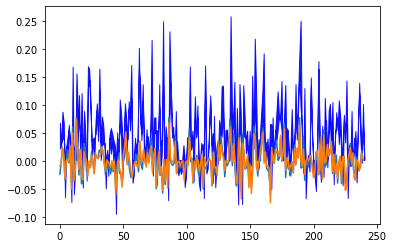

In [34]:
from ssapp.data.Metrics import relRMSE_pytorch
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad():

    output = model(train_parameters)
    predictions = likelihood(output)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


print(relRMSE_pytorch(torch.tensor(mean),train_fields))


from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(mean[:,0])
ax.plot(train_fields[:,0])
#ax.plot(mean[:,0]+lower[:,0])
x = np.linspace(0,len(mean),len(mean))
print(mean.shape,upper.shape,lower.shape,x.shape)
ax.fill_between(x, (mean[:,0]-lower[:,0]), (mean[:,0]+upper[:,0]), color='b', alpha=.9)